# 0: Setup


In [61]:
from google.colab import drive

drive.mount('/content/drive')

%cd "drive/MyDrive/405_ML_Applications/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/405_ML_Applications/'
/content/drive/MyDrive/405_ML_Applications


In [62]:
!python --version

Python 3.10.11


# Part 1: Decision Tree using OOP in Python



In this notebook, we will first re-implement the decision tree model from last week using object oriented programming in Python. We will adapt the Decision Tree model to work with continuous features, and additional stopping criterion (minimum samples in split).

Furthermore, we will implement Random Subset Feature sampling in the DecisionTree Class so that we can use the tree as a base classifier for our RandomForest implementation.

In [63]:
from dataclasses import dataclass, field
from typing import List

# I rewrote the Node-class,
# I think it should be a dataclass

""" original implementation:

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None
"""

@dataclass
class Node:
  """Dataclass that represents a split-node in a desicion tree"""

  feature: int = None # index of feature col to split on
  threshold: float = None
  left: List[int] = field(default_factory=list)
  right: List[int] = field(default_factory=list)
  value: bool = None
        
  def is_leaf_node(self):
    return self.value is not None


In [64]:
import numpy as np
from collections import Counter


class DecisionTree:
    def __init__(self, min_samples_split = 2, max_depth = 100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        #feat_idxs = np.arange(self.n_features)
        
        ### Implement random subset feature sampling here ###
        ### START CODE HERE ###
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        ### END CODE HERE ###

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(feature = best_feature,
                    threshold = best_thresh, 
                    left = left, 
                    right = right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                # if information gain bigger than previous, update current used best split
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        # information gain defined as zero in these cases:
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
    
        if len(y) != 0:
            p1 = len(y[y == 1]) / len(y) 
            # For p1 = 0 and 1, set the entropy to 0 (to handle 0log0)
            if p1 != 0 and p1 != 1:
                 entropy = -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)
            else:
                 entropy = 0
        return entropy


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

## Random Forest Model Implementation 

Finally, we will implement the RandomForest model and apply it to the task of predicting burnout among CEOs of firms.

In [65]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        ### START CODE HERE ###
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]
        ### END CODE HERE ###

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        ### START CODE HERE ###
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions
        ### START CODE HERE ###

### Dataset

The dataset has several features that can be used to predict burnout for 467 CEOs using the following 5 features:
* locus of control (higher score = low perceived control)
* coping style (high score = high ability to cope with stress)
* teaching stress (high score = teaching creates a lot of stress for the person)
* research stress (high score = research creates a lot of stress for the person)
* pastoral care stress (high score = providing pastoral care creates a lot of stress for the
person)

In [68]:
import pandas as pd

# remember to upload csv file on instance:

df = pd.read_csv("data/burnout.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   burnout   467 non-null    object 
 1   loc       467 non-null    float64
 2   cope      467 non-null    float64
 3   teaching  467 non-null    float64
 4   research  467 non-null    float64
 5   pastoral  467 non-null    float64
dtypes: float64(5), object(1)
memory usage: 22.0+ KB


In [69]:
# y-values in burnout col to binary labels:
d = {'Not Burnt Out': 0,
     'Burnt Out': 1}

df['burnout'] = df['burnout'].map(d)

# split into x and y values
X = df.drop(['burnout'], axis=1).values
y = df['burnout'].values

### Splitting a Dataset into Train and Test Subsets
The following code cells in this section illustrate the process of splitting a dataset into several subsets.
One important step, prior to splitting a dataset, is shuffling it, otherwise, we may end up with unrepresentative class distributions if the dataset was sorted prior to splitting.

In [70]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(123)
permuted_indices = rng.permutation(indices)

train_size = int(0.8*X.shape[0])
train_ind = permuted_indices[:train_size]
test_ind = permuted_indices[train_size:]

X_train, y_train = X[train_ind], y[train_ind]
X_test, y_test = X[test_ind], y[test_ind]

In [71]:
y_train.shape

(373,)

In [72]:
# alternative, using sklearn function for the train test split above:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    shuffle = True, random_state = 42)

In [73]:
print(y_train.shape)
print(X_train.shape)

(373,)
(373, 5)


### Train the random forest model and use it to predict the burnout for CEOs from test data

In [74]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

clf = RandomForest(n_trees=5, n_feature=3)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc =  accuracy(y_test, predictions)
print(acc)

# acc values keep changing, hence random forest

0.9042553191489362


# Part 2: Data Science Case Study: Price forecasting with Historical Data 

Tabular modeling takes data in the form of a table (like a spreadsheet or CSV). The objective is to predict the value in one column based on the values in the other columns. In this notebook, we will look at a more general machine learning technique: decision trees, as they can give better results depending on your problem.

We will look at how we should pre-process and clean the data, as well as how to interpret the result of our models after training. First, you might want to install the following packages using conda in your conda environment: scikit-learn dtreeviz treeinterpreter waterfallcharts graphviz python-graphviz scipy


In [ ]:
!pip install scikit-learn dtreeviz treeinterpreter waterfallcharts graphviz scipy

In [78]:
import pandas as pd
import re
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from sklearn import tree
from sklearn.impute import SimpleImputer
from dtreeviz.trees import * # generic import, not best practice

import scipy
from scipy.cluster import hierarchy as hc
#from sklearn.inspection import plot_partial_dependence
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [77]:
## annoying thing: dtreeviz visulizatuions seem to use Arial font as default with no way of changing
# it (w.o. changing the sourcecode),
# so I add this font manually to matplotlib, since google colab's virtual machines don't
# have it per default

from matplotlib import font_manager

font_dirs = ['data/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
print(font_files)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

font_manager.findfont("Arial")

['/content/drive/MyDrive/405_ML_Applications/data/arial.ttf']


'/content/drive/MyDrive/405_ML_Applications/data/arial.ttf'

# The Dataset

The data set we use in this notebook is from the Blue Book for Bulldozers Kaggle competition, which has the following description: "The goal of the contest is to predict the sale price of a particular piece of heavy equipment at auction based on its usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations." This is a very common type of dataset and prediction problem, similar to what you may see in your project or workplace. The dataset is available for download on Kaggle, a website that hosts data science competitions.

Kaggle also provides information about some of the fields of our data: 

- `SalesID`:: The unique identifier of the sale.
- `MachineID`:: The unique identifier of a machine.  A machine can be sold multiple times.
- `saleprice`:: What the machine sold for at auction (only provided in *train.csv*).
- `saledate`:: The date of the sale.

Generally, it's a good idea to take a look at your data to make sure you understand the format, how it's stored, what types of values it holds, etc.

Let's load the data and have a look at the columns: 

In [132]:
df = pd.read_csv('./data/TrainAndValid.csv', low_memory=False)
df_test = pd.read_csv('./data/Test.csv', low_memory=False)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [109]:
list(df.select_dtypes(['int64']).columns)

['SalesID', 'MachineID', 'ModelID', 'datasource', 'YearMade']

When looking at the individual columns, we find that they contain different data types such as categorical, ordinal data, dates etc. 

The column `state` is an example of a *categorical variable*: 

In [110]:
df['state'].unique()

array(['Alabama', 'North Carolina', 'New York', 'Texas', 'Arizona',
       'Florida', 'Illinois', 'Oregon', 'Ohio', 'Arkansas', 'Wisconsin',
       'Kansas', 'Nevada', 'Iowa', 'Maine', 'Massachusetts', 'California',
       'Louisiana', 'Minnesota', 'New Hampshire', 'Idaho', 'Michigan',
       'Mississippi', 'Georgia', 'Missouri', 'South Carolina', 'Utah',
       'Tennessee', 'Washington', 'Virginia', 'South Dakota',
       'West Virginia', 'Oklahoma', 'Pennsylvania', 'Wyoming',
       'North Dakota', 'New Jersey', 'Kentucky', 'Montana', 'Alaska',
       'Nebraska', 'Maryland', 'Hawaii', 'Colorado', 'New Mexico',
       'Indiana', 'Connecticut', 'Delaware', 'Rhode Island', 'Vermont',
       'Washington DC', 'Puerto Rico', 'Unspecified'], dtype=object)

The variable `ProductSize` in the data set is an *ordinal column*. This refers to columns containing strings or similar, but where those strings have a natural ordering. 

In [111]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

The data set also contains *dates*, for example the variable `salesdate`.  

In [112]:
df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

# Pre-Processing

In [133]:
# change our dependent y var "SalesPrice" into log SalesPrice values

dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

First, let us do some data pre-processing to be able to perform techniques like decision trees and random forests.

### 1) Handling ordinal data
We define how to handle ordinal columns by telling Pandas about a suitable ordering of the levels. 

In [134]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [135]:
ordered_sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [136]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(ordered_sizes, ordered=True)

In [137]:
df['ProductSize'].unique()

[NaN, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact']
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

### 2) Handling dates

The fundamental basis of the decision tree that we just described is bisection— dividing a group into two. We look at the ordinal variables and divide up the dataset based on whether the variable's value is greater (or lower) than a threshold, and we look at the categorical variables and divide up the dataset based on whether the variable's level is a particular level. So this algorithm has a way of dividing up the dataset based on both ordinal and categorical data.

But how does this apply to a common data type, the date? You might want to treat a date as an ordinal value, because it is meaningful to say that one date is greater than another. However, dates are a bit different from most ordinal values in that some dates are qualitatively different from others in a way that that is often relevant to the systems we are modeling.

In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

The functions *make_date* and *add_datepart* make sure that the data column is in dtype date and add a set of metadata columns that are relevant to the column of interest, e.g. in our case we add columns that are relevant to the variable `salesdate`. 

In [138]:
def make_date(df, date_field): 
    field_type = df[date_field].dtype
    if not np.issubdtype(field_type, np.datetime64): 
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

In [139]:
def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
    make_date(df, field_name)
    field = df[field_name]
    
    prefix =  re.sub('[Dd]ate$', '', 'saledate') if prefix == None else prefix
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    
    week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
    mask = ~field.isna()
    df[prefix + 'Elapsed'] = np.where(mask,field.values.astype(np.int64) // 10 ** 9,np.nan)
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

add_datepart(df, 'saledate')

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
0       1139246  11.097410     999089     3157         121           3.0   
1       1139248  10.950807     117657       77         121           3.0   
2       1139249   9.210340     434808     7009         121           3.0   
3       1139251  10.558414    1026470      332         121           3.0   
4       1139253   9.305651    1057373    17311         121           3.0   
...         ...        ...        ...      ...         ...           ...   
412693  6333344   9.210340    1919201    21435         149           2.0   
412694  6333345   9.259131    1882122    21436         149           2.0   
412695  6333347   9.433484    1944213    21435         149           2.0   
412696  6333348   9.210340    1794518    21435         149           2.0   
412697  6333349   9.472705    1944743    21436         149           2.0   

        YearMade  MachineHoursCurrentMeter UsageBand fiModelDesc  ... saleDay  \
0           2004                      68.0       Low        521D  ...      16   
1           1996                    4640.0       Low      950FII  ...      26   
2           2001                    2838.0      High         226  ...      26   
3           2001                    3486.0      High    PC120-6E  ...      19   
4           2007                     722.0    Medium        S175  ...      23   
...          ...                       ...       ...         ...  ...     ...   
412693      2005                       NaN       NaN        30NX  ...       7   
412694      2005                       NaN       NaN       30NX2  ...      28   
412695      2005                       NaN       NaN        30NX  ...      28   
412696      2006                       NaN       NaN        30NX  ...       7   
412697      2006                       NaN       NaN       30NX2  ...      28   

       saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start  \
0                  3           320            False              False   
1                  4            86            False              False   
2                  3            57            False              False   
3                  3           139            False              False   
4                  3           204            False              False   
...              ...           ...              ...                ...   
412693             2            67            False              False   
412694             5            28            False              False   
412695             5            28            False              False   
412696             2            67            False              False   
412697             5            28            False              False   

       saleIs_quarter_end saleIs_quarter_start saleIs_year_end  \
0                   False                False           False   
1                   False                False           False   
2                   False                False           False   
3                   False                False           False   
4                   False                False           False   
...                   ...                  ...             ...   
412693              False                False           False   
412694              False                False           False   
412695              False                False           False   
412696              False                False           False   
412697              False                False           False   

       saleIs_year_start   saleElapsed  
0                  False  1.163635e+09  
1                  False  1.080259e+09  
2                  False  1.077754e+09  
3                  False  1.305763e+09  
4                  False  1.248307e+09  
...                  ...           ...  
412693             False  1.331078e+09  
412694             False  1.327709e+09  
412695             False  1.327709e+09  
412696             False  1.33

We can now see that there are lots of new columns in our DataFrame. 

In [140]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [121]:
df.iloc[0:5, 52:65]

saleYear  saleMonth  saleWeek  saleDay  saleDayofweek  saleDayofyear  \
0      2006         11        46       16              3            320   
1      2004          3        13       26              4             86   
2      2004          2         9       26              3             57   
3      2011          5        20       19              3            139   
4      2009          7        30       23              3            204   

   saleIs_month_end  saleIs_month_start  saleIs_quarter_end  \
0             False               False               False   
1             False               False               False   
2             False               False               False   
3             False               False               False   
4             False               False               False   

   saleIs_quarter_start  saleIs_year_end  saleIs_year_start   saleElapsed  
0                 False            False              False  1.163635e+09  
1                 False            False              False  1.080259e+09  
2                 False            False              False  1.077754e+09  
3                 False            False              False  1.305763e+09  
4                 False            False              False  1.248307e+09

### 3) Handling strings and missing data

Another piece of preparatory pre-processing is to handle strings and missing data. To this end, we identify which columns are categorical and which ones are numeric. 

In [141]:
cols_cont = df.select_dtypes(include=np.number).columns.tolist()
cols_cat = df.select_dtypes(exclude=np.number).columns.tolist()

Subsequently, we convert categorical columns to numeric categorical columns. 

In [142]:
df[cols_cat] = df[cols_cat].apply(lambda x:x.astype('category').cat.codes)

We use sklearn's *SimpleImputer* function to replace missing values using the median along each column. This function can only be used with numeric data. 

In [146]:
# check if we now have only numeric data:

numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_cols = df.select_dtypes(include=numerics).columns.tolist()
print(len(num_cols))

assert(len(df.columns.tolist()) == len(num_cols))


65


In [147]:
from sklearn.impute import SimpleImputer


# get a imputer instance:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median') 
imp_mean.fit(df)

# apply to our dataframe
df = pd.DataFrame(imp_mean.transform(df), columns=df.columns)

### 4) Split data set into train and validation sets

Furthermore, we need to split the data set into training and validation sets. Ideally, we want to design the validation set in a way such that it is like the *test set* Kaggle will use to judge the competition. 

A validation set is data we hold back from training in order to ensure that the training process does not overfit on the training data. A test set is data that is held back even more deeply, from us ourselves, in order to ensure that *we* don't overfit on the validation data, as we explore various model architectures and hyperparameters.

We don't get to see the test set. But we do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.

In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series.

If you look at the date range represented in the test set, you will discover that it covers a six-month period from May 2012, which is later in time than any date in the training set. This is a good design, because the competition sponsor will want to ensure that a model is able to predict the future. But it means that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set. The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.

Let us use the `np.where` function to conditionally return row indices that correspond to train and validation examples. 

Now, let us define training and validation sets and look at their sizes.

In [151]:
# cond will split time series data into values after november 2011 and before
cond = (df.saleYear < 2011) | ((df.saleMonth < 11) & (df.saleYear < 2012))
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

df_train = df.loc[train_idx]
df_valid = df.loc[valid_idx]

In [152]:
len(df_train), len(df_valid)

(395371, 17327)

### 5) Define dependent variable

Let us define the dependent variable, which is the data column we would like to predict. Recall, that a model's metric is a function that reflects how good the predictions are. Generally, selecting the metric is an important part of the project setup. However, in this case Kaggle tells us, which metric to use: root mean squared error (RMSLE) between the actual and predicted auction prices.

In [154]:
y = (df_train['SalePrice']) 
valid_y = (df_valid['SalePrice'])

xs = df_train.loc[:, df_train.columns != 'SalePrice']
valid_xs = df_valid.loc[:, df_valid.columns != 'SalePrice']

In [ ]:
# When the columns are not a MultiIndex, df.columns is just an array of column names so you can do:

# df.loc[:, df.columns != 'b']

Since are data is now all numeric, and there are no missing values, we are ready to explore our first machine learning algorithm for tabular data: decision trees.

# Decision Tree Regresssion

Decision tree ensembles, that, as the name suggests, rely on decision trees. A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.

We use sklearn's function *DecisionTreeRegressor* to create a decision tree with 4 leaf nodes. 

In [155]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

To see what it's learned, we can display the tree: 

[Text(0.6, 0.875, 'Coupler_System <= -0.5\nsquared_error = 0.48\nsamples = 395371\nvalue = 10.102'),
 Text(0.4, 0.625, 'YearMade <= 1991.5\nsquared_error = 0.416\nsamples = 352660\nvalue = 10.21'),
 Text(0.2, 0.375, 'squared_error = 0.373\nsamples = 153675\nvalue = 9.969'),
 Text(0.6, 0.375, 'ProductSize <= 3.5\nsquared_error = 0.368\nsamples = 198985\nvalue = 10.397'),
 Text(0.4, 0.125, 'squared_error = 0.309\nsamples = 177000\nvalue = 10.493'),
 Text(0.8, 0.125, 'squared_error = 0.174\nsamples = 21985\nvalue = 9.622'),
 Text(0.8, 0.625, 'squared_error = 0.115\nsamples = 42711\nvalue = 9.206')]

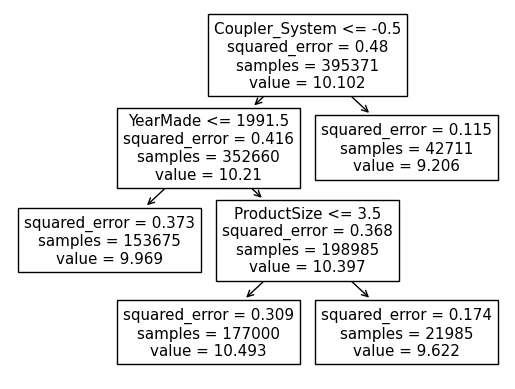

In [156]:
tree.plot_tree(m, feature_names= xs.columns)

The top node represents the initial model before any splits have been done, when all the data is in one group. This is the simplest possible model. It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset. In this case, we can see it predicts a value of 10.10 for the sales price. It gives a mean squared error of 0.48. We can also see that there are 404,710 auction records in this group—that is the total size of our training set. The final piece of information shown here is the decision criterion for the best split that was found, which is to split based on the `coupler_system` column.

Moving down and to the left, this node shows us that there were 360,847 auction records for equipment where `coupler_system` was less than -0.5. The average value of our dependent variable in this group is 10.21. Moving down and to the right from the initial model takes us to the records where `coupler_system` was greater than -0.5.

The bottom row contains our *leaf nodes*: the nodes with no answers coming out of them, because there are no more questions to be answered. At the far right of this row is the node containing records where `ProductSize` was greater than 3.5. The average value here is 9.62, so we can see the decision tree algorithm did find a single binary decision that separated high-value from low-value auction results. Asking only about `coupler_system` predicts an average value of 9.62 versus 10.1.

We can show the same information using the *dtreeviz* library: 

In [158]:
import dtreeviz

samp_idx = np.random.permutation(len(y))[:500]

m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs.values, y)

viz_model = dtreeviz.model(m, 
                           X_train = xs.iloc[samp_idx],
                           y_train = y.iloc[samp_idx], 
                           feature_names = xs.columns,
                           target_name = dep_var)

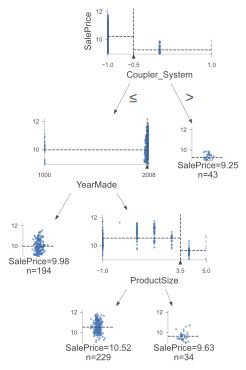

In [159]:
viz_model.view()

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our `YearMade` data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization of the values we are interested in more difficult. So, let's replace it with 1950:

In [ ]:
xs.loc[xs.YearMade < 1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs.YearMade < 1900, 'YearMade'] = 1950

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

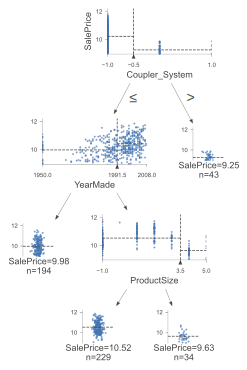

In [161]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs.values, y);

viz_model = dtreeviz.model(m, 
                           X_train = xs.iloc[samp_idx],
                           y_train = y.iloc[samp_idx], 
                           feature_names = xs.columns,
                           target_name = dep_var)

viz_model.view()

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as `max_leaf_nodes`:

In [163]:
m_big = DecisionTreeRegressor()
m_big.fit(xs, y);

We'll create a little function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:

In [164]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [165]:
m_rmse(m_big, xs, y)

0.0

So, our model is perfect, right? Not so fast... remember we really need to check the validation set, to ensure we're not overfitting. 

In [166]:
m_rmse(m_big, valid_xs, valid_y)

0.370224

It looks like we're overfitting very badly. Here's why: 

In [168]:
m_big.get_n_leaves(), len(xs)

(333329, 395371)

We've got nearly as many leaf nodes as data points! That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 examples:

In [169]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.211519, 0.282178)

That looks more reasonable. Let's check the number of leaves again: 

In [170]:
m.get_n_leaves()

12097

Much more reasonable!

# Random Forest Regression

Next, we will combine multiple versions of a predictor (multiple decision trees) to make more accurate predicitons over a single tree. 

This procedure is known as "bagging." It is based on a deep and important insight: although each of the models trained on a subset of data will make more errors than a model trained on the full dataset, those errors will not be correlated with each other. Different models will make different errors. The average of those errors, therefore, is: zero! So if we take the average of all of the models' predictions, then we should end up with a prediction that gets closer and closer to the correct answer, the more models we have. This is an extraordinary result—it means that we can improve the accuracy of nearly any kind of machine learning algorithm by training it multiple times, each time on a different random subset of the data, and averaging its predictions.

In essence a random forest is a model that averages the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters. Bagging is a particular approach to "ensembling," or combining the results of multiple models together. To see how it works in practice, let's get started on creating our own random forest!

## Creating a Random Forest

We can create a random forest just like we created a decision tree, except now, we are also specifying parameters that indicate how many trees should be in the forest, how we should subset the data items (the rows), and how we should subset the fields (the columns).

In the following function definition n_estimators defines the number of trees we want, max_samples defines how many rows to sample for training each tree, and max_features defines how many columns to sample at each split point (where 0.5 means "take half the total number of columns"). We can also specify when to stop splitting the tree nodes, effectively limiting the depth of the tree, by including the same min_samples_leaf parameter we used in the last section. Finally, we pass n_jobs=-1 to tell sklearn to use all our CPUs to build the trees in parallel. By creating a little function for this, we can more quickly try different variations in the rest of this notebook:


In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m = rf(xs, y);

Our validation RMSE is now much improved over our last result produced by the `DecisionTreeRegressor`, which made just one tree using all the available data:

In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.017016, 0.02413)

One of the most important properties of random forests is that they aren't very sensitive to the hyperparameter choices, such as `max_features`. You can set `n_estimators` to as high a number as you have time to train—the more trees you have, the more accurate the model will be. `max_samples` can often be left at its default, unless you have over 200,000 data points, in which case setting it to 200,000 will make it train faster with little impact on accuracy. `max_features=0.5` and `min_samples_leaf=4` both tend to work well, although sklearn's defaults work well too.

## Out-of-Bag Error

The performance on our validation set is worse than on our training set. But is that because we're overfitting, or because the validation set covers a different time period, or a bit of both? With the existing information we've seen, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error that can help us with this (and more!).


Recall that in a random forest, each tree is trained on a different subset of the training data. The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training. This allows us to see whether the model is overfitting, without needing a separate validation set.

This is particularly beneficial in cases where we have only a small amount of training data, as it allows us to see whether our model generalizes without removing items to create a validation set. The OOB predictions are available in the `oob_prediction_` attribute. Note that we compare them to the training labels, since this is being calculated on trees using the training set.

In [ ]:
r_mse(m.oob_prediction_, y)

0.021061

# Model Interpretation

For tabular data, model interpretation is particularly important. For a given model, the things we are most likely to be interested in are:

* How confident are we in our predictions using a particular row of data?
* For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
* Which columns are the strongest predictors, which can we ignore?
* Which columns are effectively redundant with each other, for purposes of prediction?
* How do predictions vary, as we vary these columns?

As we will see, random forests are particularly well suited to answering these questions. Let's start with the first one!


## Exercise 1: Tree Variance for Prediction Confidence

We saw how the model averages the individual tree's predictions to get an overall prediction—that is, an estimate of the value. But how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the relative confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

In the next code snippet compute the prediction confidence of the first 5 examples in your validation set:

In the earlier section on creating a random forest, we saw how to get predictions over the validation set, using a Python list comprehension to do this for each tree in the forest.

Once we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set, we can get the standard deviation of the predictions over all the trees, for each auction:

In [ ]:
### BEGIN YOUR CODE ###
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])
preds_std = preds.std(0) # why specify the argument 0? # we want std per row right?
preds_std[:5]
### END YOUR CODE ###

array([0.02488896, 0.02176887, 0.02715109, 0.01695356, 0.01645823])

As you can see, the confidence in the predictions varies widely. For some auctions, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using this model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

##  Feature Importance

It's not normally enough just to know that a model can make accurate predictions—we also want to know *how* it's making predictions. *feature importance* gives us insight into this. We can get these directly from sklearn's random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

In [171]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) `YearMade` and `Coupler_System` being at the top of the list:

In [172]:
fi = rf_feat_importance(m, xs)
fi[:10]

cols       imp
37      Coupler_System  0.223255
5             YearMade  0.184560
13         ProductSize  0.135399
14  fiProductClassDesc  0.120267
2              ModelID  0.097763
63         saleElapsed  0.075042
10     fiSecondaryDesc  0.029427
8          fiModelDesc  0.027467
19           Enclosure  0.024825
0              SalesID  0.019926

A plot of the feature importances shows the relative importances more clearly:

<Axes: ylabel='cols'>

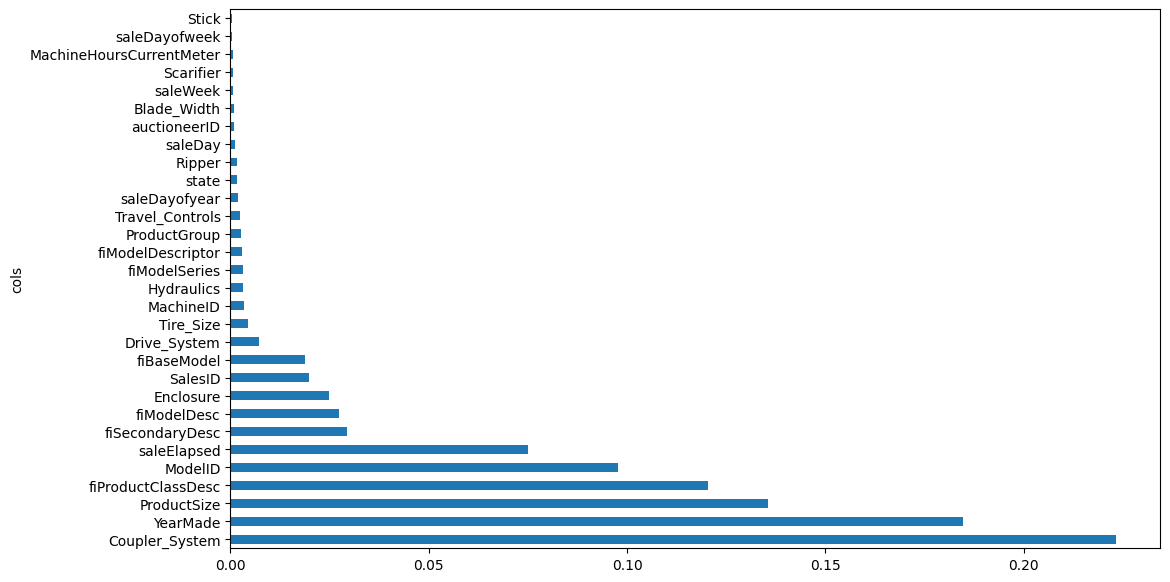

In [173]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

## Exercise 3: Removing Redundant Features 

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings: for example, `ProductGroup` and `ProductGroupDesc`. Let's try to remove any redundent features. 

Let's try removing some of these closely related features to see if the model can be simplified without impacting the accuracy. First, we create a function that quickly trains a random forest and returns the OOB score, by using a lower `max_samples` and higher `min_samples_leaf`. The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 for a random model.  We don't need it to be very accurate—we're just going to use it to compare different models, based on removing some of the possibly redundant columns.

Now we try removing each of our potentially redundant variables ('saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup','fiModelDesc', 'fiBaseModel','Hydraulics_Flow','Grouser_Tracks', 'Coupler_System'), one at a time. If the OOB error doesn't chance significantly, remove this feature from the dataset.

After removing all redundant features, retrain the random forest model again and report the training and validation error.

In [176]:
# this will take some time (2-3 min to execute)

canidates_rem_cols = ('saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
                      'fiModelDesc', 'fiBaseModel','Hydraulics_Flow',
                      'Grouser_Tracks', 'Coupler_System')

oob_scores = {}

for col in canidates_rem_cols:
  rf_regr = RandomForestRegressor(n_estimators=40, max_samples=50_000,
       max_features=0.5, min_samples_leaf=80, random_state=0, oob_score = True)
  
  fitted = rf_regr.fit(xs.loc[:, xs.columns != col], y)
  
  # add to dict:
  oob_scores[col] = fitted.oob_score_


In [190]:
# print results ( with some f string formatting)

for k, v in oob_scores.items():
  print(f"{k:<17} -> {v:^8.4f}")


saleYear          ->  0.8324 
saleElapsed       ->  0.8283 
ProductGroupDesc  ->  0.8351 
ProductGroup      ->  0.8351 
fiModelDesc       ->  0.8336 
fiBaseModel       ->  0.8334 
Hydraulics_Flow   ->  0.8349 
Grouser_Tracks    ->  0.8350 
Coupler_System    ->  0.8352 


In [191]:
rem_cols = list(canidates_rem_cols)
rem_cols.remove('saleElapsed') # we dont want to remove saleElapsed

assert(len(rem_cols) == len(canidates_rem_cols) - 1)

['saleYear', 'ProductGroupDesc', 'ProductGroup', 'fiModelDesc', 'fiBaseModel', 'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System']


In [192]:
cols = [col for col in xs.columns if col not in rem_cols]

xs.shape, xs[cols].shape

((395371, 64), (395371, 56))

In [193]:
rf_regr = RandomForestRegressor(n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, random_state=0)

rf_rem_redundant = rf_regr.fit(xs[cols], y)

m_rmse(rf_rem_redundant, xs[cols], y), m_rmse(rf_rem_redundant, valid_xs[cols], valid_y)


(0.175726, 0.253477)

## Partial Dependence

By focusing on the most important variables, and removing some redundant ones, we've greatly simplified our model. Now, let's see how those variables affect our predictions using partial dependence plots.

As we've seen, the two most important predictors are `ProductSize` and `YearMade`. We'd like to understand the relationship between these predictors and sale price. It's a good idea to first check the count of values per category (provided by the Pandas `value_counts` method), to see how common each category is:

Let's do the same for `YearMade`... Since this is a numeric feature, we'll need to draw a histogram, which groups the year values into a few discrete bins:

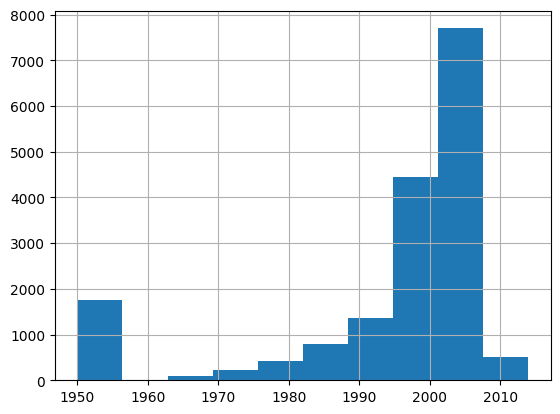

In [194]:
ax = valid_xs['YearMade'].hist()

Other than the special value 1950 which we used for coding missing year values, most of the data is from after 1990.

Now we're ready to look at *partial dependence plots*. Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For instance, how does `YearMade` impact sale price, all other things being equal?

To answer this question, we can't just take the average sale price for each `YearMade`. The problem with that approach is that many other things vary from year to year as well, such as which products are sold, how many products have air-conditioning, inflation, and so forth. So, merely averaging over all the auctions that have the same `YearMade` would also capture the effect of how every other field also changed along with `YearMade` and how that overall change affected price.

Instead, what we do is replace every single value in the `YearMade` column with 1950, and then calculate the predicted sale price for every auction, and take the average over all auctions. Then we do the same for 1951, 1952, and so forth until our final year of 2011. This isolates the effect of only `YearMade` (even if it does so by averaging over some imagined records where we assign a `YearMade` value that might never actually exist alongside some other values). 

With these averages, we can then plot each of these years on the x-axis, and each of the predictions on the y-axis. This, finally, is a partial dependence plot. Let's take a look:

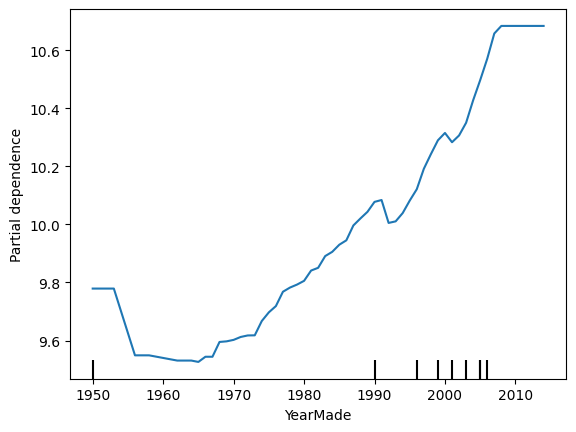

In [195]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(m, valid_xs, ['YearMade'])


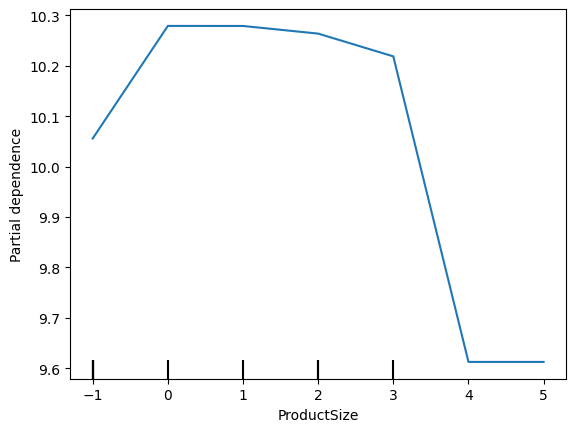

In [196]:

PartialDependenceDisplay.from_estimator(m, valid_xs, ['ProductSize'])

In [197]:
valid_xs['ProductSize'].unique()

array([-1.,  4.,  2.,  3.,  1.,  5.,  0.])

Looking first of all at the `YearMade` plot, and specifically at the section covering the years after 1990 (since as we noted this is where we have the most data), we can see a nearly linear relationship between year and price. Remember that our dependent variable is after taking the logarithm, so this means that in practice there is an exponential increase in price. This is what we would expect: depreciation is generally recognized as being a multiplicative factor over time, so, for a given sale date, varying year made ought to show an exponential relationship with sale price.

The `ProductSize` partial plot is a bit concerning. It shows that the final group, which we saw is for missing values, has the lowest price. To use this insight in practice, we would want to find out *why* it's missing so often, and what that *means*. Missing values can sometimes be useful predictors—it entirely depends on what causes them to be missing.

## conclusion


We've discussed a popular approach to machine learning with tabular data: decision trees. Furthermore, we've mentioned two different decision tree ensembles, namely bagging & random forests.

Random forests are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees.

We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.